# Text to Speech Pytorch

###### https://pytorch.org/audio/stable/tutorials/tacotron2_pipeline_tutorial.html

In [ ]:
%%bash
pip3 install deep_phonemizer

In [ ]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt

In [ ]:
torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.1.0+cu121
2.1.0+cu121
cuda


### **Text Processing**


In [ ]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

In [ ]:
def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

In [ ]:
text = "Hello world! I am a bot that can do Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 20, 11, 12, 24, 11, 12, 11, 13, 26, 31, 11, 31, 19, 12, 31, 11, 14, 12, 25, 11, 15, 26, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [ ]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = text
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 20, 11, 12, 24, 11,
         12, 11, 13, 26, 31, 11, 31, 19, 12, 31, 11, 14, 12, 25, 11, 15, 26, 11,
         31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([51], dtype=torch.int32)


In [ ]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 'i', ' ', 'a', 'm', ' ', 'a', ' ', 'b', 'o', 't', ' ', 't', 'h', 'a', 't', ' ', 'c', 'a', 'n', ' ', 'd', 'o', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### **Phoneme-based encoding**

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! I am a bot that can do Text to speech!"
with torch.inference_mode():
  processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 32, 11, 16, 66, 11, 20, 11,
         36, 12, 81, 11, 39, 16, 81, 11, 64, 16, 67, 11, 38, 87, 11, 81, 40, 64,
         79, 81, 11, 81, 20, 11, 79, 77, 59, 37,  2]])
tensor([47], dtype=torch.int32)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'AY', ' ', 'AE', 'M', ' ', 'AH', ' ', 'B', 'AA', 'T', ' ', 'DH', 'AE', 'T', ' ', 'K', 'AE', 'N', ' ', 'D', 'UW', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


### **Spectrogram Generation**

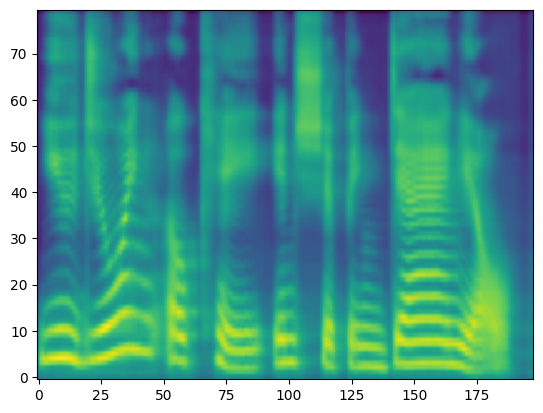

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2= bundle.get_tacotron2().to(device)

text = "You doing okay in shipping Daniel? "

with torch.inference_mode():
  processed , lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec,_,_ = tacotron2.infer(processed,lengths)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 208])
torch.Size([80, 215])
torch.Size([80, 179])


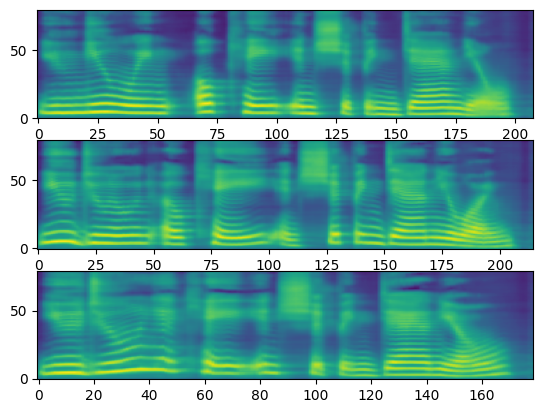

In [ ]:
def plot():
  fig, ax = plt.subplots(3,1)
  for i in range(3):
    with torch.inference_mode():
      spec, spec_lengths, _ = tacotron2.infer(processed,lengths)
      print(spec[0].shape)
      ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

plot()

### **Waveform Generation**

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
vocoder = bundle.get_vocoder().to(device)

text = "Hey whats up mike! I coded this bot "

with torch.inference_mode():
  processed , lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec,spec_legnths,_ = tacotron2.infer(processed,lengths)
  waveforms, lengths = vocoder(spec, spec_legnths)

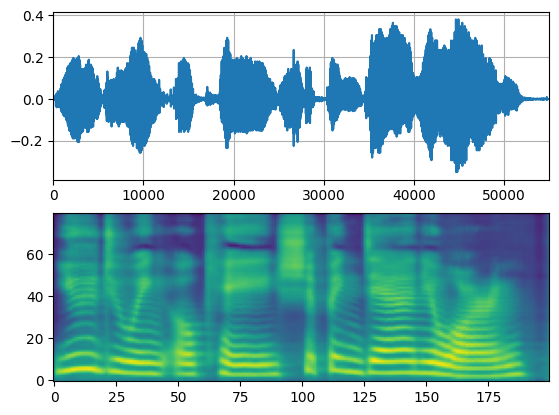

In [ ]:
# More human like voice
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

### **Griffin-Lim**



In [ ]:
# more bot like voice
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hey whats up mike! I coded this bot "

with torch.inference_mode():
  processed , lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec,spec_legnths,_ = tacotron2.infer(processed,lengths)
  waveforms, lengths = vocoder(spec, spec_legnths)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


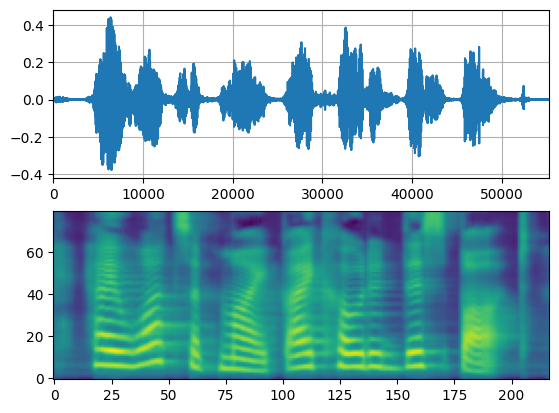

In [ ]:
plot(waveforms, spec, vocoder.sample_rate)

### **Waveglow**
> pretrained model by nvida

In [ ]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


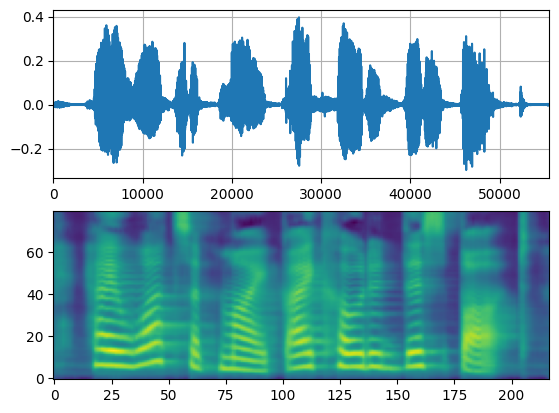

In [ ]:
plot(waveforms, spec, 22050)
